<a href="https://colab.research.google.com/github/catastropiyush/coursework-notebooks/blob/main/Hyperparameter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# see: http://lukemetz.com/exploring-hyperparameter-meta-loss-landscapes-with-jax/ for more info

In [ ]:
# # Make sure the Colab Runtime is set to Accelerator: TPU.
# # This is boilerplate needed to leverage TPU's (though this notebook will run fine on any hardware.)
# import requests
# import os
# if 'TPU_DRIVER_MODE' not in globals():
#   url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
#   resp = requests.post(url)
#   TPU_DRIVER_MODE = 1

# # The following is required to use TPU Driver as JAX's backend.
# from jax.config import config
# config.FLAGS.jax_xla_backend = "tpu_driver"
# config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']
# print(config.FLAGS.jax_backend_target)

grpc://10.101.64.122:8470


In [1]:
import jax
#import jax.tools.colab_tpu
#jax.tools.colab_tpu.setup_tpu()
import jax.numpy as jnp
from matplotlib import pylab as plt

Text(0, 0.5, 'inner-loss')

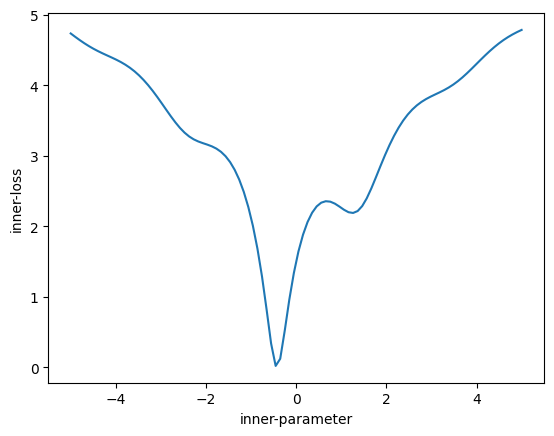

In [2]:
@jax.jit
def inner_loss(x):
  #return jnp.log(x**2 + 1.0 + jnp.sin(x*3)*0.5) + 1.5
  return jnp.log(x**2 + 1.0 + jnp.sin(x*3)) + 1.5

xs = jnp.linspace(-5, 5, 100)
plt.plot(xs, jax.vmap(inner_loss)(xs))
plt.xlabel("inner-parameter")
plt.ylabel("inner-loss")

Text(0, 0.5, 'inner-loss')

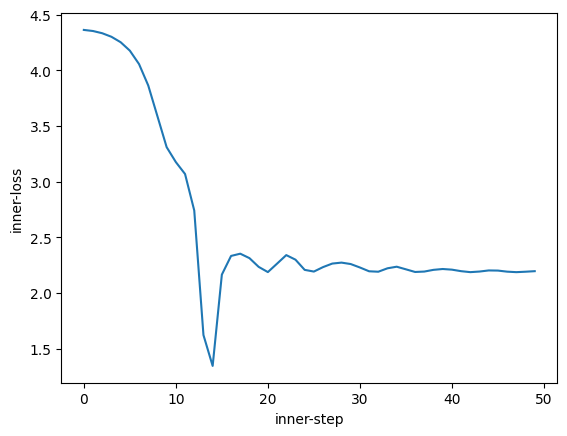

In [3]:
x = -4. # initial inner parameter
v = 0.0 # initial momentum accumulator

lr = 0.1
mom = 0.9

value_and_grad_fn = jax.jit(jax.value_and_grad(inner_loss))

losses = []
for i in range(50):
  loss, grad = value_and_grad_fn(x)
  v= mom*v + grad
  x = x - lr * v
  losses.append(loss)
plt.plot(losses)
plt.xlabel("inner-step")
plt.ylabel("inner-loss")

In [4]:
@jax.jit
def outer_loss(lr, mom):
  value_and_grad_fn = jax.jit(jax.value_and_grad(inner_loss))

  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

outer_loss(0.1, 0.9)

Array(2.611698, dtype=float32)

Text(0, 0.5, 'outer-loss')

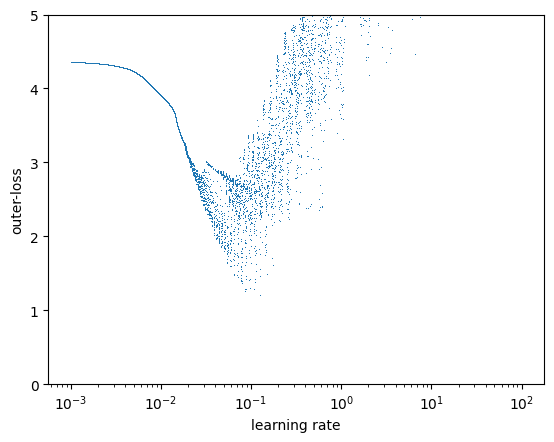

In [5]:
lrs = jnp.logspace(-3, 2, 10000)
plt.semilogx(lrs, jax.jit(jax.vmap(outer_loss, in_axes=(0, None)))(lrs, 0.9), ",")
plt.ylim(0.0, 5.0)
plt.xlabel("learning rate")
plt.ylabel("outer-loss")

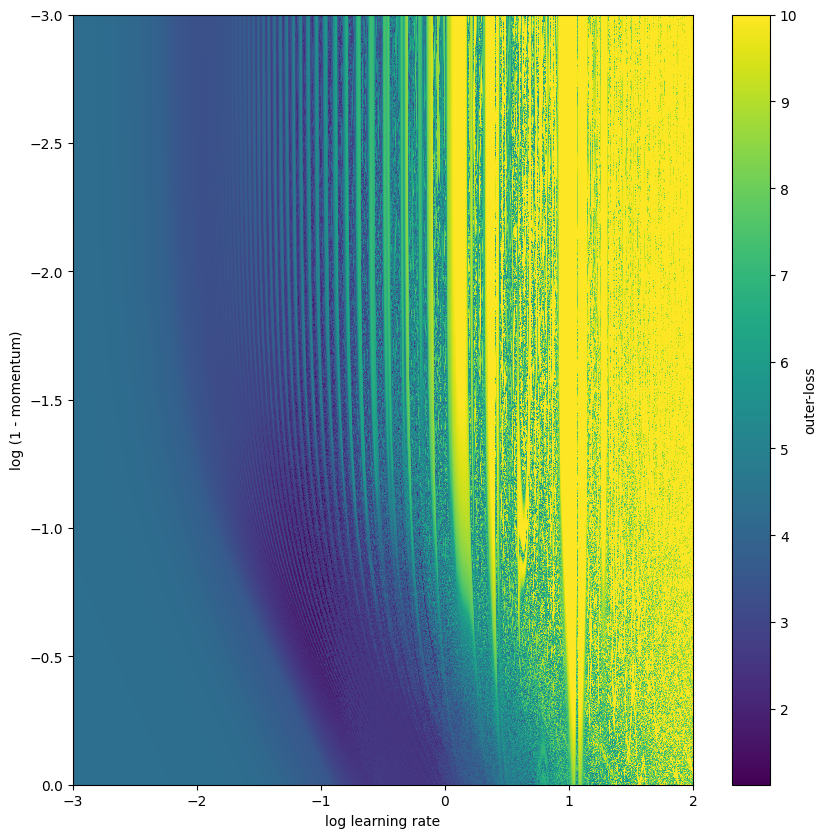

In [6]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img_fn = jax.vmap(jax.vmap(outer_loss))

plt.figure(figsize=(10,10))
img = img_fn(lrs, moms)

plt.imshow(img, extent=[-3, 2, 0, -3], aspect="auto", interpolation="nearest", vmax=10)
plt.xlabel("log learning rate")
plt.ylabel("log (1 - momentum)")
cbar = plt.colorbar()
cbar.set_label("outer-loss")

# Good init

In [9]:
@jax.jit
def outer_loss(outer_params):
  log_lr, one_minus_log_mom = outer_params
  lr = jnp.power(10, log_lr)
  mom = 1.0 - jnp.power(10, one_minus_log_mom)
  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

outer_grad_fn = jax.jit(jax.value_and_grad(outer_loss))

outer_params = (-2., -0.5)

outer_params_traj = [outer_params]

losses = []
grads = []
alpha = 0.01
for i in range(100):
  loss, outer_grad = outer_grad_fn(outer_params)
  grads.append(outer_grad)
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)
  # The following line has been changed from jax.tree_multimap to jax.tree_util.tree_map
  outer_params = jax.tree_util.tree_map(lambda a,b: a-alpha*b, outer_params, outer_grad)
  outer_params_traj.append(outer_params)
  losses.append(loss)

<ipython-input-9-f1385b3ade92>:28: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)


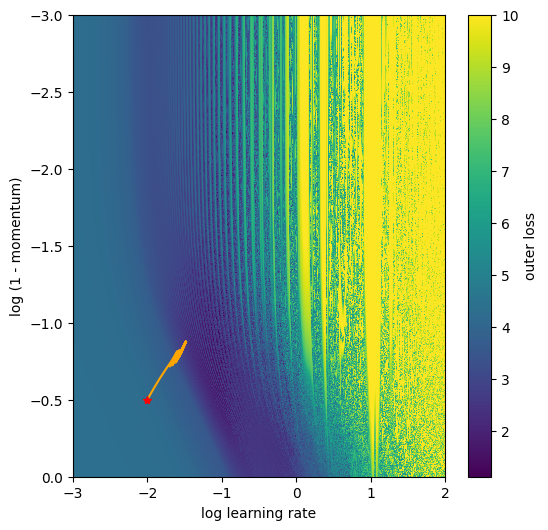

In [10]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img = img_fn(lrs, moms)
plt.figure(figsize=(6,6))

plt.imshow(img, extent=[-3, 2, 0, -3], interpolation="nearest", vmax=10, aspect="auto")
plt.xlabel("log learning rate")
plt.ylabel("log (1 - momentum)")
cbar = plt.colorbar()
cbar.set_label("outer loss")

log_lrs, one_minus_log_moms = list(zip(*outer_params_traj))
plt.plot(log_lrs[0:1000], one_minus_log_moms[0:1000], "-", color="orange")
plt.plot(log_lrs[0:1], one_minus_log_moms[0:1], "*", color="red")

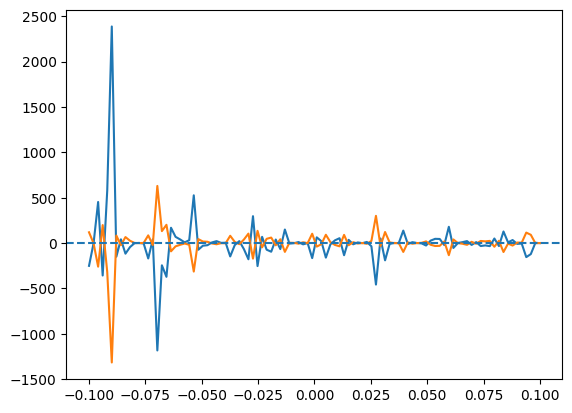

In [11]:
ts = jnp.linspace(-0.1, 0.1, 100)
ggs = jax.jit(jax.vmap(jax.grad(outer_loss), in_axes=((None, 0), )))((outer_params[0], outer_params[1] + ts))
g_lr, g_mom = ggs
plt.plot(ts, g_lr)
plt.plot(ts, g_mom)
plt.axhline(y=0, linestyle="--")

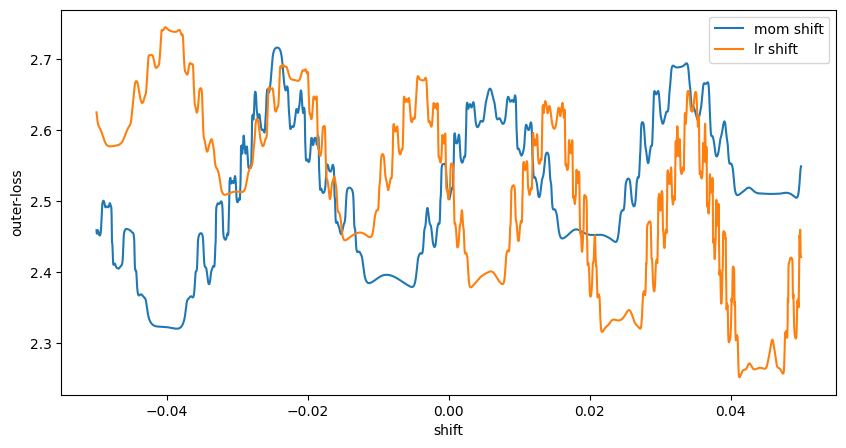

In [12]:
plt.figure(figsize=(10, 5))

ts = jnp.linspace(-0.05, 0.05, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((None, 0), )))((outer_params[0], outer_params[1] + ts))
plt.plot(ts, vs, label="mom shift")

ts = jnp.linspace(-0.05, 0.05, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((0, None), )))((outer_params[0]+ts, outer_params[1]))
plt.plot(ts, vs, label="lr shift")

plt.ylabel("outer-loss")
plt.xlabel("shift")
plt.legend()

# Bad init

In [14]:
@jax.jit
def outer_loss(outer_params):
  log_lr, one_minus_log_mom = outer_params
  lr = jnp.power(10, log_lr)
  mom = 1.0 - jnp.power(10, one_minus_log_mom)
  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

outer_grad_fn = jax.jit(jax.value_and_grad(outer_loss))


outer_params = (0., -1.5)
clip_params = [outer_params]

losses = []
grads = []
alpha = 0.01
for i in range(500):
  loss, outer_grad = outer_grad_fn(outer_params)
  grads.append(outer_grad)
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)
  # The following line has been changed from jax.tree_multimap to jax.tree_util.tree_map
  outer_params = jax.tree_util.tree_map(lambda a,b: a-alpha*b, outer_params, outer_grad)
  clip_params.append(outer_params)
  losses.append(loss)
  print(loss, outer_params, outer_grad)

<ipython-input-14-2a822b8c08a0>:28: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)


7.0248423 (Array(-0.09999999, dtype=float32, weak_type=True), Array(-1.4, dtype=float32, weak_type=True)) (Array(10., dtype=float32, weak_type=True), Array(-10., dtype=float32, weak_type=True))
8.649832 (Array(-0.19999999, dtype=float32, weak_type=True), Array(-1.3744454, dtype=float32, weak_type=True)) (Array(10., dtype=float32, weak_type=True), Array(-2.555453, dtype=float32, weak_type=True))
4.7272205 (Array(-0.09999999, dtype=float32, weak_type=True), Array(-1.4744455, dtype=float32, weak_type=True)) (Array(-10., dtype=float32, weak_type=True), Array(10., dtype=float32, weak_type=True))
8.799201 (Array(-0.13199352, dtype=float32, weak_type=True), Array(-1.4594698, dtype=float32, weak_type=True)) (Array(3.199352, dtype=float32, weak_type=True), Array(-1.4975637, dtype=float32, weak_type=True))
7.2054114 (Array(-0.23199351, dtype=float32, weak_type=True), Array(-1.4136952, dtype=float32, weak_type=True)) (Array(10., dtype=float32, weak_type=True), Array(-4.5774593, dtype=float32, wea

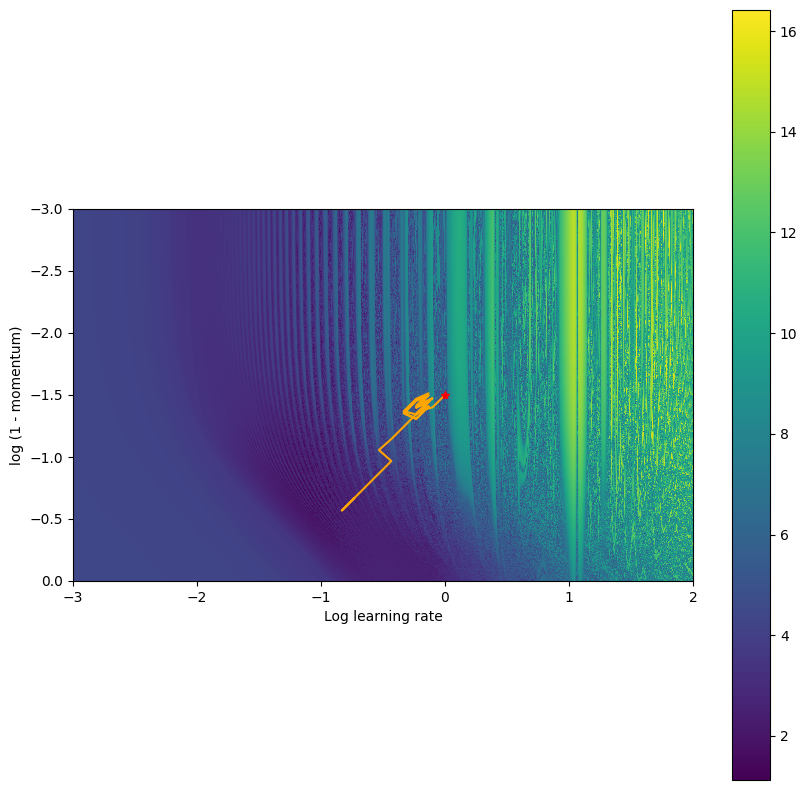

In [15]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img = img_fn(lrs, moms)
plt.figure(figsize=(10,10))

plt.imshow(img, extent=[-3, 2, 0, -3], interpolation="nearest")
plt.xlabel("Log learning rate")
plt.ylabel("log (1 - momentum)")
plt.colorbar()

log_lrs, one_minus_log_moms = list(zip(*clip_params))
plt.plot(log_lrs[0:4000], one_minus_log_moms[0:4000], "-", color="orange")
plt.plot(log_lrs[0:1], one_minus_log_moms[0:1], "*", color="red")

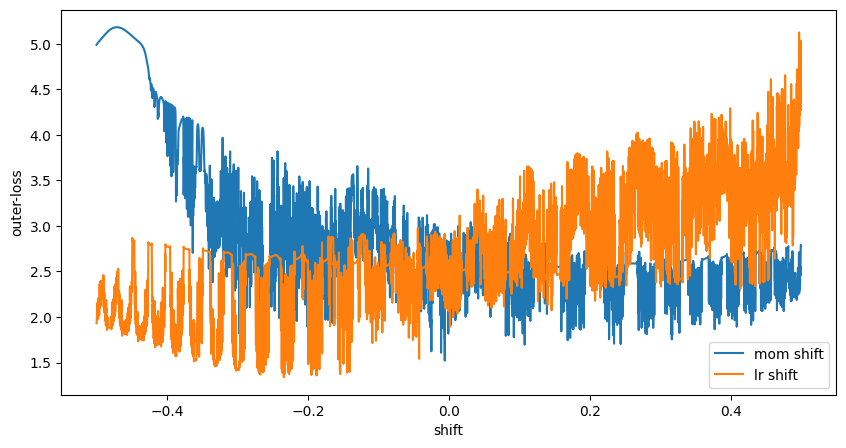

In [16]:
plt.figure(figsize=(10, 5))

ts = jnp.linspace(-0.5, 0.5, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((None, 0), )))((outer_params[0], outer_params[1] + ts))
plt.plot(ts, vs, label="mom shift")

ts = jnp.linspace(-0.5, 0.5, 5000)
vs = jax.jit(jax.vmap(outer_loss, in_axes=((0, None), )))((outer_params[0]+ts, outer_params[1]))
plt.plot(ts, vs, label="lr shift")

plt.ylabel("outer-loss")
plt.xlabel("shift")
plt.legend()

In [18]:
@jax.jit
def outer_loss(outer_params):
  log_lr, one_minus_log_mom = outer_params
  lr = jnp.power(10, log_lr)
  mom = 1.0 - jnp.power(10, one_minus_log_mom)
  x = -4.
  v = 0.0
  losses = []
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
    losses.append(loss)
  return jnp.mean(jnp.asarray(losses))

@jax.jit
def outer_gradient_es(outer_params, key, std):
  lr_noise, mom_noise = jax.random.normal(key, [2])*std
  outer_params_pos = (outer_params[0] + lr_noise, outer_params[1]+mom_noise)
  outer_params_neg = (outer_params[0] - lr_noise, outer_params[1]-mom_noise)
  pos_loss = outer_loss(outer_params_pos)
  neg_loss = outer_loss(outer_params_neg)

  factor = (pos_loss - neg_loss) / (2 * std**2)
  outer_grad = (lr_noise * factor, mom_noise * factor)
  return (pos_loss + neg_loss) / 2, outer_grad

@jax.jit
def batch_outer_gradient_es(outer_params, key):
  n_sample = 16
  losses, grads = jax.vmap(outer_gradient_es, in_axes=(None, 0))(outer_params, jax.random.split(key, n_sample))
  return jnp.mean(losses), jax.tree_map(lambda x: jnp.mean(x, axis=0), grads)

outer_params = (0., -1.5)
clip_params = [outer_params]

losses = []
grads = []
alpha = 0.003
key = jax.random.PRNGKey(0)
for i in range(1000):
  key, key1 = jax.random.split(key)
  std = 0.1

  loss, outer_grad = outer_gradient_es(outer_params, key1, std)

  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)

  grads.append(outer_grad)
  # The following line has been changed from jax.tree_multimap to jax.tree_util.tree_map
  outer_params = jax.tree_util.tree_map(lambda a, b: a - alpha * b, outer_params, outer_grad)
  clip_params.append(outer_params)
  losses.append(loss)
  print(loss, outer_params, outer_grad)

<ipython-input-18-15c7ccc1dd7d>:47: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)


6.0054684 (Array(-0.00706449, dtype=float32), Array(-1.4807255, dtype=float32)) (Array(2.3548315, dtype=float32), Array(-6.424813, dtype=float32))


<ipython-input-18-15c7ccc1dd7d>:47: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  outer_grad = jax.tree_map(lambda x: jnp.clip(x, -10.0, 10.0), outer_grad)


5.7006636 (Array(-0.00678121, dtype=float32), Array(-1.482316, dtype=float32)) (Array(-0.09442822, dtype=float32), Array(0.53016436, dtype=float32))
8.999696 (Array(-0.01828751, dtype=float32), Array(-1.4908625, dtype=float32)) (Array(3.835432, dtype=float32), Array(2.8488314, dtype=float32))
8.482866 (Array(-0.04828751, dtype=float32), Array(-1.5208625, dtype=float32)) (Array(10., dtype=float32), Array(10., dtype=float32))
7.5042953 (Array(-0.07064559, dtype=float32), Array(-1.532634, dtype=float32)) (Array(7.452692, dtype=float32), Array(3.9238575, dtype=float32))
6.5793934 (Array(-0.06314215, dtype=float32), Array(-1.5181295, dtype=float32)) (Array(-2.5011454, dtype=float32), Array(-4.834841, dtype=float32))
6.1899767 (Array(-0.09314215, dtype=float32), Array(-1.4888902, dtype=float32)) (Array(10., dtype=float32), Array(-9.746429, dtype=float32))
6.9822216 (Array(-0.09145039, dtype=float32), Array(-1.489399, dtype=float32)) (Array(-0.56391984, dtype=float32), Array(0.1695942, dtype=

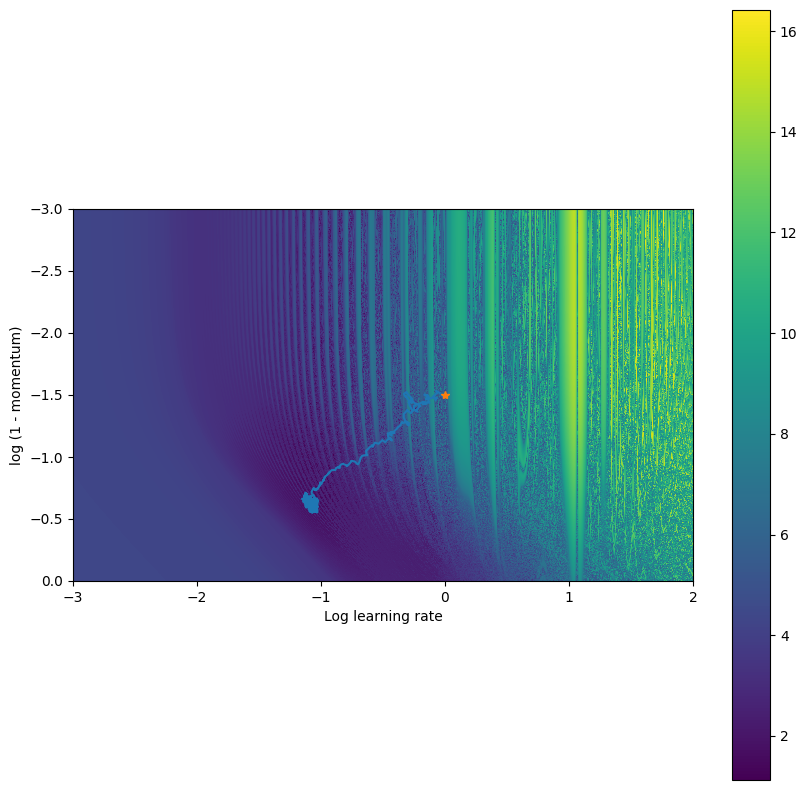

In [19]:
lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img = img_fn(lrs, moms)
plt.figure(figsize=(10,10))

plt.imshow(img, extent=[-3, 2, 0, -3], interpolation="nearest")
plt.xlabel("Log learning rate")
plt.ylabel("log (1 - momentum)")
plt.colorbar()

log_lrs, one_minus_log_moms = list(zip(*clip_params))
plt.plot(log_lrs[0:1000], one_minus_log_moms[0:1000], "-")
plt.plot(log_lrs[0:1], one_minus_log_moms[0:1], "*")
# lrs = jnp.exp(jnp.asarray(log_lrs))
# moms = 1.0 - jnp.exp(jnp.asarray(one_minus_log_moms))
#plt.xlim(-3, 2)

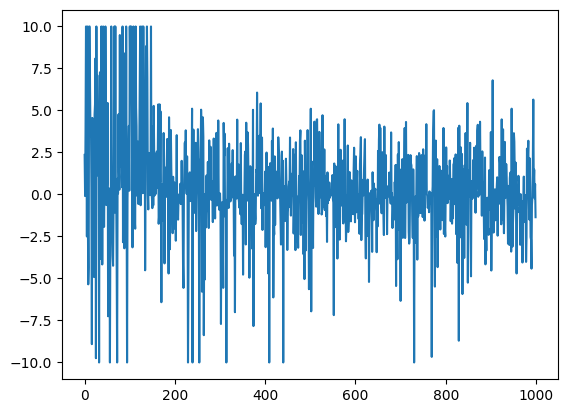

In [20]:
lr_grad, mom_grad = list(zip(*grads))
plt.plot(lr_grad)

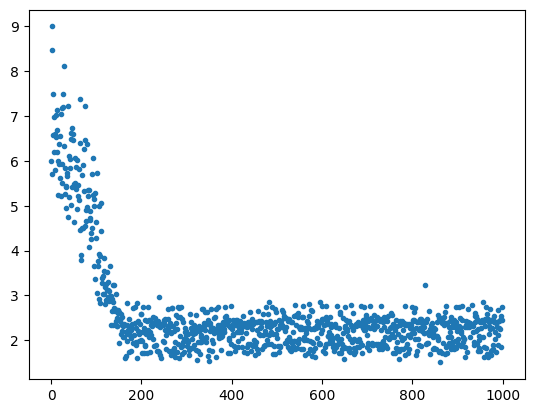

In [21]:
plt.plot(losses, '.')

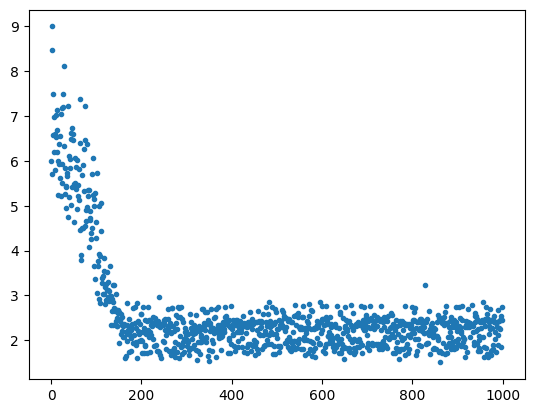

In [22]:
plt.plot(losses, '.')

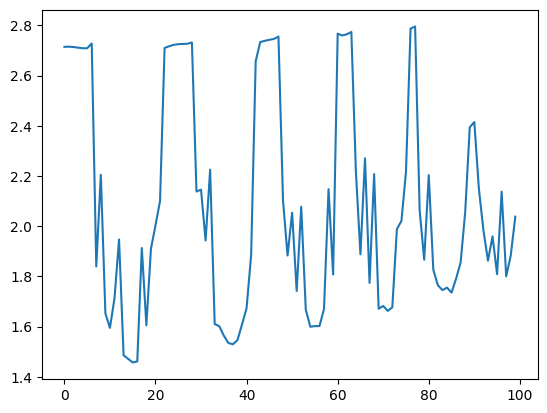

In [23]:
#ts = jnp.linspace(0.1, 0.1, 100)
ts = jnp.linspace(-1, 1, 100)
ts = jnp.linspace(-0.1, 0.1, 100)
#inp_params = jax.vmap(lambda a, t: (a[0], a[1]+t), in_axes=(None, 0))(outer_params, ts)
#print(inp_params)

plt.plot(jax.vmap(outer_loss, in_axes=((None, 0), ))((outer_params[0], outer_params[1] + ts)))
#plt.plot(jax.vmap(outer_loss, in_axes=((0, None), ))((outer_params[0]+ts, outer_params[1])))

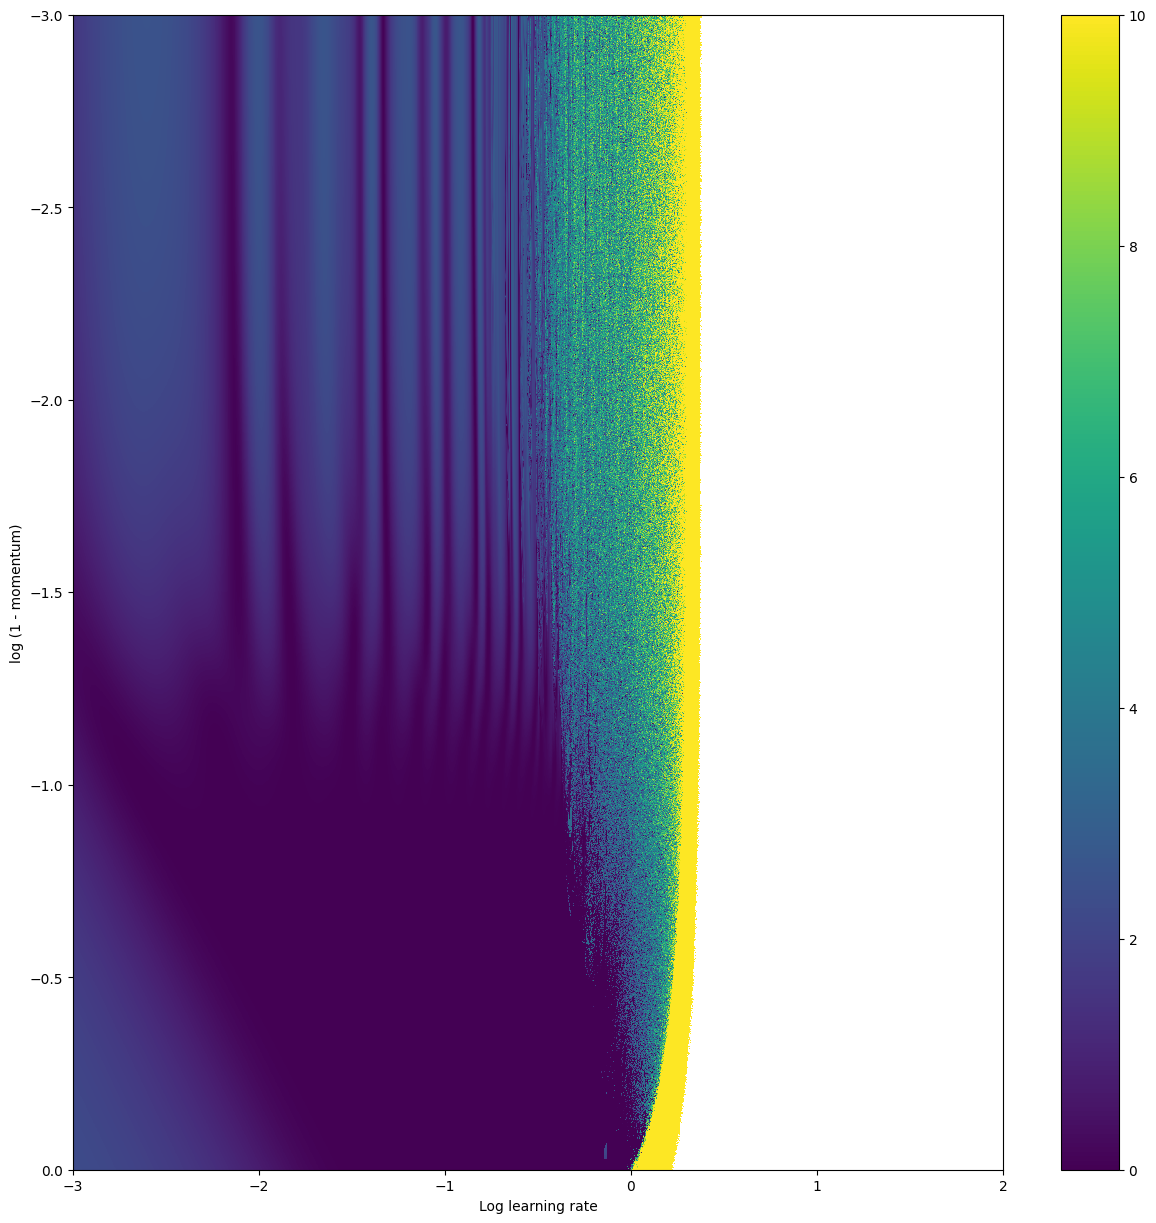

In [24]:
@jax.jit
def inner_loss(x):
  #return jnp.clip((x[0] + jnp.cos(x[1]))**2 + x[1]**2 + 1., 0, 1000)
  return (x[0] + jnp.cos(x[1]))**2 + x[1]**2 + 1.

value_and_grad_fn = jax.jit(jax.value_and_grad(inner_loss))

@jax.jit
def outer_loss(lr, mom):
  x = jnp.asarray([-4., 1.0])
  v = jnp.asarray([0.0, 0.0])
  for i in range(50):
    loss, grad = value_and_grad_fn(x)
    v= mom*v + grad
    x = x - lr * v
  return loss

lrs = jnp.logspace(-3, 2, 2000)
moms = 1. - jnp.logspace(-3, 0, 2000)
lrs, moms = jnp.meshgrid(lrs, moms)

img_fn = jax.vmap(jax.vmap(outer_loss))

plt.figure(figsize=(15,15))
plt.imshow(jnp.log(img_fn(lrs, moms)), extent=[-3, 2, 0, -3], aspect="auto", interpolation="nearest", vmin=0.0, vmax=10)
plt.xlabel("Log learning rate")
plt.ylabel("log (1 - momentum)")
plt.colorbar()